# OpenCV 图像操作

In [1]:
# -*- coding: utf-8 -*- 
import numpy as np
import cv2 as cv
import matplotlib
import matplotlib.pylab as plt
from pylab import mpl
import time
%matplotlib inline

In [2]:
class Point:
    def __int__(self, x, y, f):
        self.x = x
        self.y = y
        self.f = f
        
def Linear(J, Q11, Q21, Q12=None, Q22=None, methord='bi'):
    """
    单/双线性插值
    """
    x, y = J.x, J.y
    x1, y1 = Q11.x, Q11.y
    x2, y2 = Q22.x, Q22.y
    X = np.array([x2 - x, x - x1])
    F = np.array([[Q11.f, Q12.f], [Q21.f, Q22.f]])
    Y = np.array([y2 - y, y - y1]).T
    if methord == 'bi':
        return 1 / (x2 - x1) / (y2 - y1) * X @ F @ Y
    else:
        return (x2 - x) / (x2 - x1) * Q11.f + (x - x1) / (x2 - x1) * Q21.f

## 图像基本操作

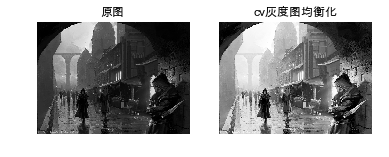

In [3]:
img = cv.imread('d.jpg')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img_gray, cmap="gray"), plt.axis('off'),plt.title(u'原图')
img_eq = cv.equalizeHist(img_gray)
plt.subplot(122)
plt.imshow(img_eq, cmap='gray'), plt.axis('off'), plt.title(u'cv灰度图均衡化')
plt.show()

## 直方图

### 3种直方图方法对比

<class 'numpy.ndarray'> (256, 1)
cv2.calcHist方法 0.006281852722167969
<class 'numpy.ndarray'> (256,)
np.bincount方法 0.04661989212036133
<class 'numpy.ndarray'> (256,)
plt.hist方法 0.35323619842529297


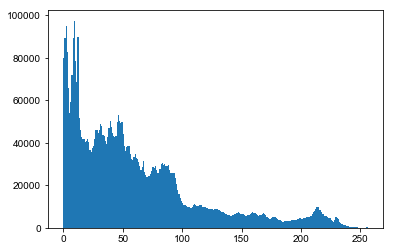

In [4]:
ti = time.time()
h  = cv.calcHist([img],[0],None,[256],[0, 256])
h += cv.calcHist([img],[1],None,[256],[0, 256])
h += cv.calcHist([img],[2],None,[256],[0, 256])
print(type(h),h.shape)
print('cv2.calcHist方法', time.time()-ti)
ti = time.time()
h = np.bincount(img.ravel(), minlength=256)
print(type(h),h.shape)
print('np.bincount方法', time.time()-ti)
ti = time.time()
h = plt.hist(img.ravel(), bins=256, range=[0, 256])[0]
print(type(h),h.shape)
print('plt.hist方法', time.time()-ti)

## 使用plt绘制直方图

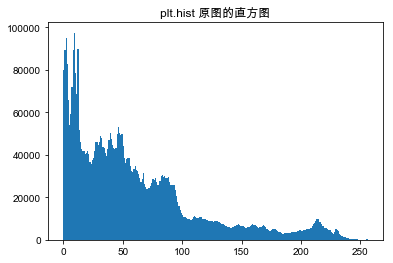

0.8828296661376953


In [5]:
ti = time.time()
h = plt.hist(img.ravel(), bins=256, range=[0, 256])[0];
plt.title('plt.hist 原图的直方图'), plt.show()
print(time.time()-ti)

## cv.calcHist+plt.plot 原图的直方图

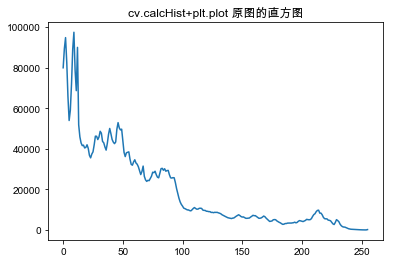

0.1921842098236084


In [6]:
ti = time.time()
h  = cv.calcHist([img],[0],None,[256],[0, 256])
h += cv.calcHist([img],[1],None,[256],[0, 256])
h += cv.calcHist([img],[2],None,[256],[0, 256])
plt.plot(h), plt.title('cv.calcHist+plt.plot 原图的直方图')
plt.show()
print(time.time()-ti)

## np.bincount+plt.plot 原图的直方图

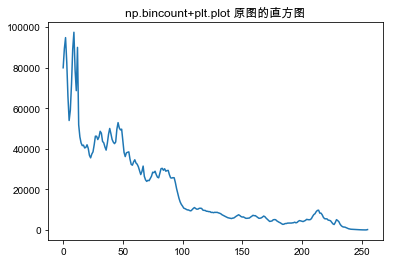

0.27304506301879883


In [7]:
ti = time.time()
h = np.bincount(img.ravel(), minlength=256)
plt.plot(h),plt.title('np.bincount+plt.plot 原图的直方图')
plt.show()
print(time.time()-ti)

## 直方图函数总结:  
| 方法|时间 |
|:-----:|:------:|
|`cv2.calcHist`*3| 0.0066  |  
|`np.bincount` | 0.0324 |  
|plt.hist(绘图)|  0.350 |  

opencv求直方图非常快,而且返回的是标准的矩形  
绘图上bincount和cv2.calcHist花费的时间一致，但是bincount只要一行,cv需要手动加通道  
plt.hist在这里表现一般  

## RGB图像直方图

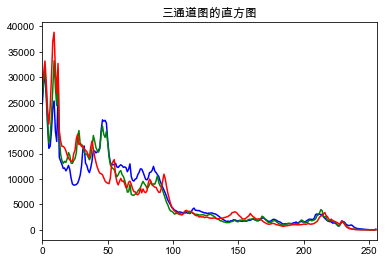

In [8]:
colorbgr = ('b', 'g', 'r')
for i, col in enumerate(colorbgr):
    histr = cv.calcHist([img], [i], None, [256], [0,256])
    plt.plot(histr, col)
    plt.xlim([0,256])
plt.title(u'三通道图的直方图')
plt.show()

## 手工实现直方图均衡化

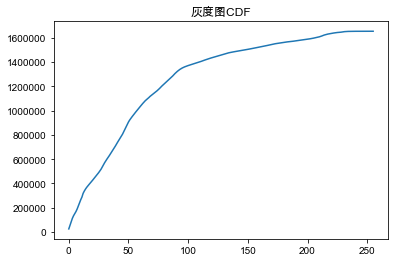

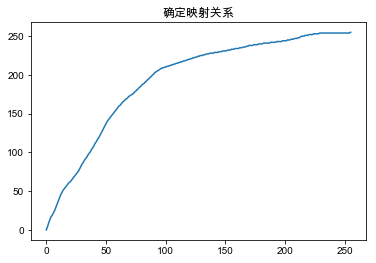

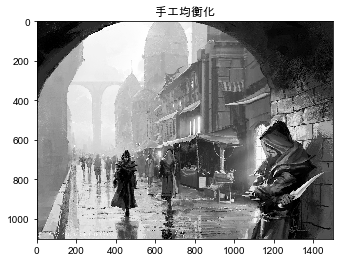

0.6714119911193848


In [9]:
ti = time.time()
cdf = cv.calcHist([img_gray], [0], None, [256], [0,256]).cumsum()
plt.plot(cdf), plt.title('灰度图CDF')
plt.show()
# 使用掩码数组优化
cdf_m = np.ma.masked_equal(cdf, 0) # no need hand on cdf=0
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')
plt.plot(cdf), plt.title('确定映射关系')
plt.show()
img_gray_eq = cdf[img_gray]
plt.imshow(img_gray_eq, cmap='gray'),plt.title(u'手工均衡化')
plt.show()
print(time.time()-ti)

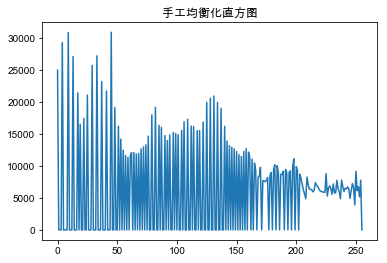

In [10]:
h = cv.calcHist([img_gray_eq], [0], None, [256], [0, 256])
plt.plot(h),plt.title('手工均衡化直方图')
plt.show()

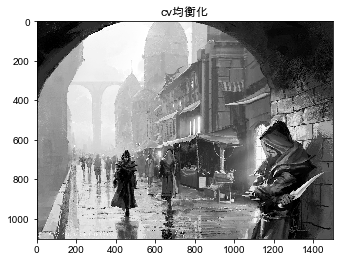

0.298691987991333


In [11]:
ti = time.time()
img_gray_eq = cv.equalizeHist(img_gray)
plt.imshow(img_gray_eq, cmap='gray'), plt.title('cv均衡化')
plt.show()
print(time.time()-ti)

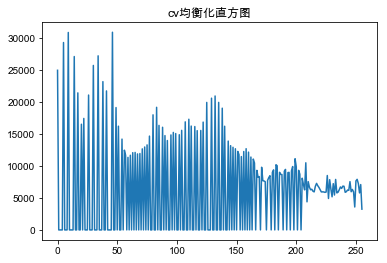

In [12]:
h = cv.calcHist([img_gray_eq], [0], None, [256], [0, 256])
plt.plot(h), plt.title('cv均衡化直方图')
plt.show()

## RGB三通道图均衡化

In [13]:
B, G, R = img[:,:,0],img[:,:,1],img[:,:,2] # or use cv.split(img)

In [14]:
B = cv.equalizeHist(B)
G = cv.equalizeHist(G)
R = cv.equalizeHist(R)
img_rgb_merge = np.dstack([B,G,R]) # or use cv.merge(B,G,R)

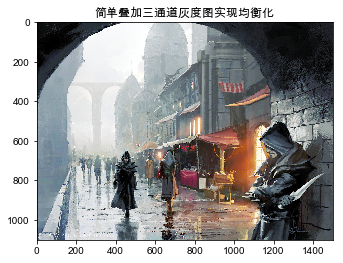

In [15]:
plt.imshow(img_rgb_merge), plt.title('简单叠加三通道灰度图实现均衡化')
plt.show()
# cv.imwrite(img_rgb_merge, 'aaa.jpg')

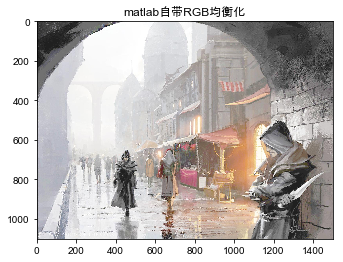

In [16]:
matlab_eq_d = cv.imread('matlab_eq_d.jpg')
matlab_eq_d = cv.cvtColor(matlab_eq_d, cv.COLOR_BGR2RGB)
plt.imshow(matlab_eq_d), plt.title('matlab自带RGB均衡化')
plt.show()